In [1]:

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize
# from simpeg import dask
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation, MetaSimulation


Solver = get_default_solver()


directory = "../synthetic-data-10m"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.split(".")[-1]=="txt"]

files.remove("rx_locs.txt")
# rx_locs = np.loadtxt(f"{directory}/rx_locs.txt")
# rx_locs[:, 1] =
tx_height = 30 

rx_x = (np.linspace(-400, 400, 81))[::4]

rx_y = np.r_[-160, -120, -80, -40, 0, 40, 80, 120, 160]
# rx_y = np.r_[-80, -40, 0, 40, 80]

rx_z = tx_height

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
rx_x

# rx_times = np.loadtxt(f"{directory}/rx_times.txt")
rx_times = np.logspace(np.log10(2e-5), np.log10(2e-3), 20)
np.save("rx_times.npy", rx_times)

In [2]:
rx_x

array([-400., -360., -320., -280., -240., -200., -160., -120.,  -80.,
        -40.,    0.,   40.,   80.,  120.,  160.,  200.,  240.,  280.,
        320.,  360.,  400.])

In [3]:
len(rx_locs[:, 0])

189

In [4]:
len(rx_x)

21

In [5]:
len(rx_locs[:, 0])

189

In [6]:
rx_times

array([2.00000000e-05, 2.54854997e-05, 3.24755348e-05, 4.13827616e-05,
       5.27330180e-05, 6.71963657e-05, 8.56266480e-05, 1.09111896e-04,
       1.39038559e-04, 1.77173358e-04, 2.25767578e-04, 2.87689978e-04,
       3.66596142e-04, 4.67144294e-04, 5.95270288e-04, 7.58538038e-04,
       9.66586048e-04, 1.23169642e-03, 1.56951994e-03, 2.00000000e-03])

In [7]:
# dobs_dict = {}

# for f in files:
#     key = f.split(".")[0]
#     dobs_dict[key] = np.loadtxt(f"{directory}/{f}")
    
# data_dict = {}
n_times_invert = 20
# for key, value in dobs_dict.items():
source_list = []
for i in range(rx_locs.shape[0]):
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times[:n_times_invert], orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)

    # data_dict[key] = Data(survey=full_survey, dobs=value)



In [8]:
# n_times_invert = 20
# data_dict_invert = {}
    
# for key, value in dobs_dict.items():

#     source_list = []

#     for i in range(rx_locs.shape[0]):
#         rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times[:n_times_invert], orientation="z")
#         src = tdem.sources.CircularLoop(
#             receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
#             waveform=tdem.sources.StepOffWaveform()
#         )
#         source_list.append(src)

#     survey = tdem.Survey(source_list)

#     data_dict_invert[key] = Data(
#         survey=survey,
#         dobs=(value.reshape(rx_locs.shape[0], len(rx_times))[:, :n_times_invert]).flatten(),
#         relative_error=0.1,
#         noise_floor=1e-11
#     )

In [9]:
survey = full_survey

In [10]:
downsample = 1
source_list_downsampled = survey.source_list[::downsample]

with open("survey.txt", "w") as f:
    f.write(f"N_TRX {len(source_list_downsampled)}\n\n")

    for src in source_list_downsampled: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]} {src.location[1]} {src.location[2]} {src.radius} 0 0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {n_times_invert}\n")
        for t in rx_times[:n_times_invert]:
            rx = src.receiver_list[0]
            f.write(f"{rx.locations[0, 0]} {rx.locations[0, 1]} {rx.locations[0, 2]} {t}\n")
        f.write("\n")
            


        

In [11]:
len(source_list_downsampled)

189

In [12]:
src = survey.source_list[0]
rx = src.receiver_list[0]

In [13]:
ubc_mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")

In [14]:
def dipping_target_indices(
    mesh, target_x_center, target_z_center, dip, target_thickness, target_xlim=None, target_ylim=None, target_zlim=None
): 
    """
    add a dipping target to the model. For now assumes the target dips in the x-direction
    """
    x_center = np.mean(target_x)
    slope = np.tan(-dip*np.pi/180)
    target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]
    
    z_bottom = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.min()
    z_top = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.max()

    indices = (
        (mesh.cell_centers[:, 2] >= z_bottom) &
        (mesh.cell_centers[:, 2] <= z_top) 
    )

    if target_xlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 0] >= target_xlim.min()) &
            (mesh.cell_centers[:, 0] <= target_xlim.max())
        )
    if target_ylim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 1] >= target_ylim.min()) &
            (mesh.cell_centers[:, 1] <= target_ylim.max())
        )
    if target_zlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 2] >= target_zlim.min()) &
            (mesh.cell_centers[:, 2] <= target_zlim.max())
        )
    return indices

In [15]:
rho_back = 500
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_dips = np.r_[0, 15, 30, 45]
target_z = np.r_[-200, -20]

In [16]:
models = {}

target_x = np.r_[-250, 250]
target_y = np.r_[-40, 40]
target_z_center = -80
target_thickness = 40

# background model
background = np.ones(ubc_mesh.n_cells) * sigma_air
background[ubc_mesh.cell_centers[:, 2] < 0] = sigma_back
models["background"] = background

for dip in target_dips:
    model = background.copy()
    indices = dipping_target_indices(
        ubc_mesh, target_x_center=-100, target_z_center=target_z_center, 
        target_thickness=target_thickness, dip=dip, 
        target_xlim=target_x, 
        target_ylim=target_y,
        target_zlim=target_z
    )
    model[indices] = sigma_target
    models[f"target_{dip}"] = model



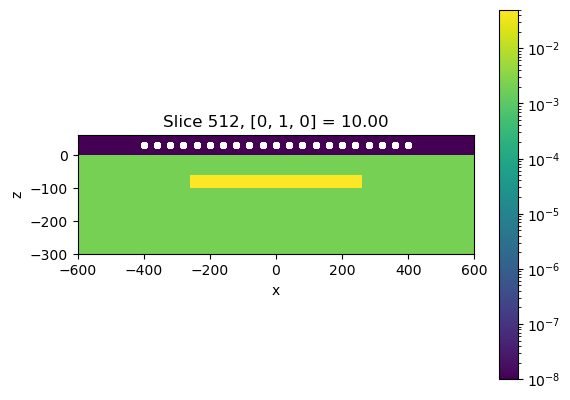

In [17]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        models["target_0"], ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Y",
    )[0], ax=ax
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 60])
ax.plot(rx_locs[:, 0], rx_locs[:, 2], "wo", ms=4)
ax.set_aspect(1)

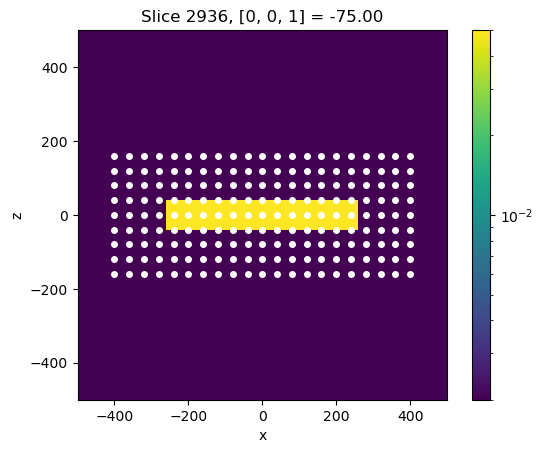

In [18]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        models["target_0"], ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Z", ind=2936
    )[0], 
    ax=ax
)

ax.set_xlim(500*np.r_[-1, 1])
ax.set_ylim(500*np.r_[-1, 1])

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax.set_aspect(1)

In [19]:
discretize.TreeMesh.write_model_UBC(ubc_mesh, "target_30.con", models["target_30"])

In [20]:
np.save("rx_locs.npy", rx_locs)

In [21]:
relative_error = 0.05
noise_floor = 1e-13

In [22]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [23]:
dobs = load_pre_file("dpred0.txt")

In [24]:
dobs_values = np.zeros((n_times_invert, len(dobs["transmitters"])))

In [25]:
for i in range(len(dobs["transmitters"])): 
    for j in range(n_times_invert): 
        dobs_values[j, i] = dobs["transmitters"][i]["receivers"][j]["data"][-1]

In [26]:
dobs_values

array([[1.376700e-07, 1.375243e-07, 1.379763e-07, ..., 1.378838e-07,
        1.378682e-07, 1.379986e-07],
       [7.964364e-08, 7.971479e-08, 8.033537e-08, ..., 7.962441e-08,
        7.966510e-08, 7.977251e-08],
       [4.449241e-08, 4.467287e-08, 4.524864e-08, ..., 4.430085e-08,
        4.435809e-08, 4.444901e-08],
       ...,
       [8.087067e-12, 8.088822e-12, 8.090584e-12, ..., 8.092618e-12,
        8.094682e-12, 8.096989e-12],
       [4.596526e-12, 4.597106e-12, 4.597621e-12, ..., 4.598650e-12,
        4.600137e-12, 4.599334e-12],
       [2.554480e-12, 2.554603e-12, 2.554645e-12, ..., 2.555088e-12,
        2.555966e-12, 2.554297e-12]])

In [27]:
data_invert = Data(survey, dobs = discretize.utils.mkvc(dobs_values))


In [28]:
len(rx_x)

21

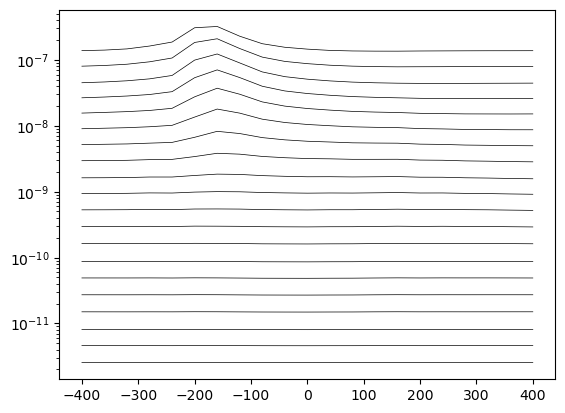

In [86]:
fig, ax = plt.subplots(1, 1)

line_number = 4

ax.semilogy(rx_x, data_invert.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :], color="k", lw=0.5);
# ax.semilogy(rx_locs[::3, 0], dpred_values.T, "C0o", ms=2);

In [30]:

source_list = data_invert.survey.source_list

with open("dobs.txt", "w") as f:
    f.write(f"IGNORE -9.9999000e+004\n")
    f.write(f"N_TRX {len(source_list)}\n\n")

    for src in source_list: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]}\t{src.location[1]}\t{src.location[2]}\t{src.radius}\t0\t0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {n_times_invert}\n")
        for i, t in enumerate(rx_times[:n_times_invert]):
            rx = src.receiver_list[0]
            datum = data_invert[src, rx][i]
            std = np.abs(datum) * relative_error + noise_floor
            f.write(
                f"{rx.locations[0, 0]}\t{rx.locations[0, 1]}\t{rx.locations[0, 2]}\t{t} "+
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # E data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # H data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t{datum}\t{std}\n"
            )
            
        f.write("\n")
            


        

In [31]:
time_steps = [
    (1e-6, 30),
    (3e-6, 30),
    (1e-5, 30), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
]

In [32]:
full_time_mesh = np.cumsum(np.hstack([0, discretize.utils.unpack_widths(time_steps)]))
with open("waveform.txt", "w") as f:
    for i, t in enumerate(full_time_mesh): 
        if i == 0:
            f.write(f"{t} \t 1\n")
        else:
            f.write(f"{t} \t 0\n")

In [33]:
# fname = "dpred0.txt"
# with open(fname, 'r') as f:
#     lines = f.readlines()



In [80]:
ubc_model = discretize.TreeMesh.read_model_UBC(ubc_mesh, "inv_006.con")

In [81]:
# with open(f"{directory}/true-models.pkl", "rb") as f:
#     true_models = pickle.load(f)

# simpeg_mesh = discretize.load_mesh(f"{directory}/treemesh.json")

In [83]:
target_x = np.r_[-250, 250]
target_y = np.r_[-40, 40]

target_z_center = -80
target_thickness = 40
target_x_center=-100
target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]

target_zlim = np.r_[-20, -200]


dip = 30
slope = np.tan(-dip*np.pi/180)

x_tmp = np.linspace(target_x.min(), target_x.max())

z_bottom = (x_tmp-target_x_center) * slope + target_z.min()
z_top = (x_tmp-target_x_center) * slope + target_z.max()

z_bottom[z_bottom < target_zlim.min()] = target_zlim.min()
z_bottom[z_bottom > target_zlim.max()] = target_zlim.max()
z_top[z_top > target_zlim.max()] = target_zlim.max()
z_top[z_top < target_zlim.min()] = target_zlim.min()

inds_equal = (z_top == z_bottom)
x_tmp = x_tmp[~inds_equal]
z_bottom = z_bottom[~inds_equal]
z_top = z_top[~inds_equal]

target_outline_x = np.hstack(
    [x_tmp, x_tmp[-1], np.flipud(x_tmp), x_tmp[0]]
)
target_outline_z = np.hstack(
    [z_bottom, z_bottom[-1], np.flipud(z_top), z_bottom[0]]
)


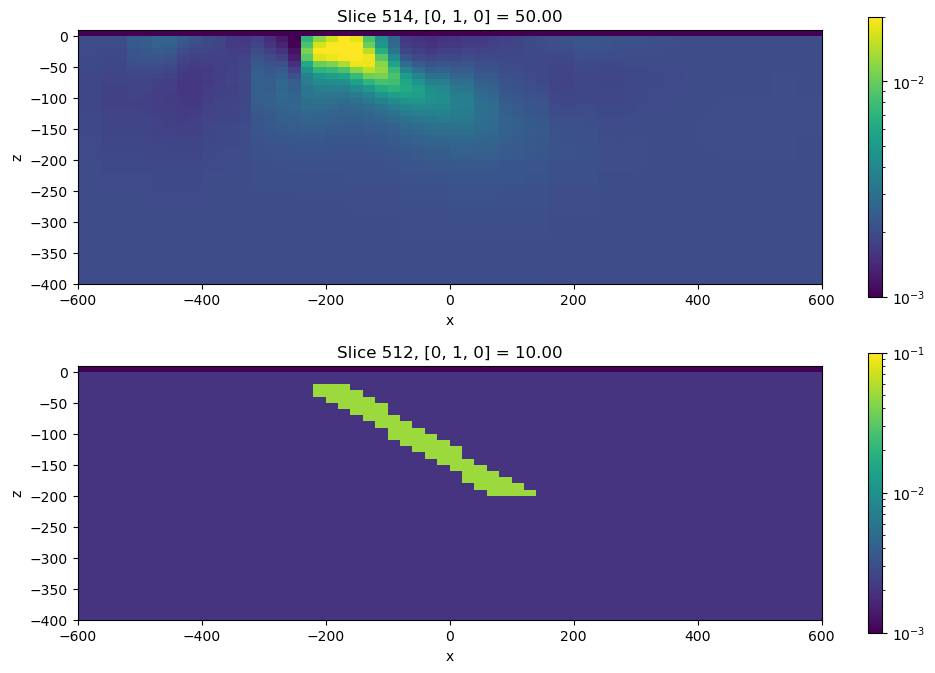

In [92]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8)) 

plt.colorbar(ubc_mesh.plot_slice(
    ubc_model, 
    pcolor_opts={"norm":LogNorm(vmin=1e-3, vmax=2e-2)},
    ax=ax[0],
    normal="Y",
    ind = 514, 
    # grid=True,
)[0], ax=ax[0])

# ax[0].plot(target_outline_x, target_outline_z, color="k")

plt.colorbar(ubc_mesh.plot_slice(
    models["target_30"], 
    pcolor_opts={"norm":LogNorm(vmin=1e-3, vmax=1e-1)},
    ax=ax[1],
    normal="Y",
    # ind=513
)[0], ax=ax[1])


for a in ax: 
    a.set_xlim(600* np.r_[-1, 1])
    a.set_ylim(-400, 10)
    a.set_aspect(1)

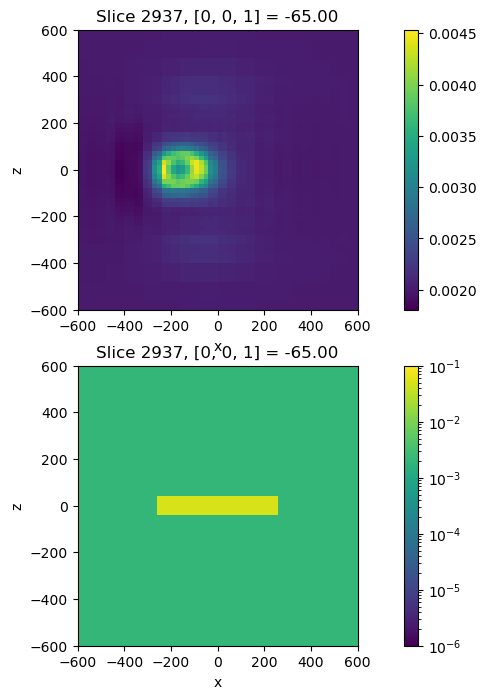

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8)) 
ind = 2937
plt.colorbar(ubc_mesh.plot_slice(
    ubc_model, 
    # pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax[0],
    normal="Z",
    ind=ind,
    # grid=True,
)[0], ax=ax[0])

plt.colorbar(ubc_mesh.plot_slice(
    models["target_0"], 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax[1],
    normal="Z",
    ind=ind,
)[0], ax=ax[1])


for a in ax: 
    a.set_xlim(600* np.r_[-1, 1])
    a.set_ylim(600* np.r_[-1, 1])
    a.set_aspect(1)

In [29]:
# small_mesh = discretize.TreeMesh.read_UBC("octree_mesh_0050.txt")

NameError: name 'small_mesh' is not defined

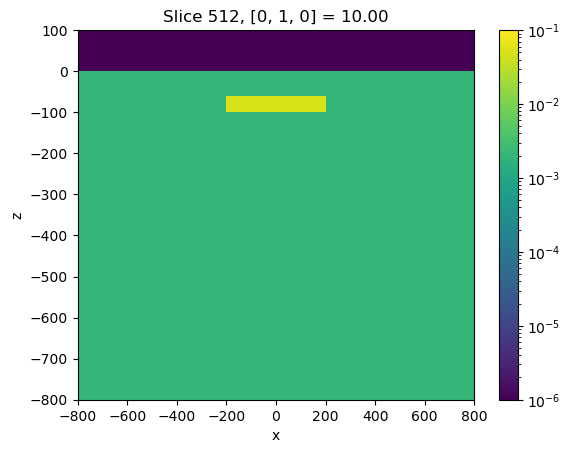

In [30]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ubc_mesh.plot_slice(
    models["target_0"], 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax,
    normal="Y"
)[0], ax=ax)

ax.set_xlim(np.r_[-1, 1]*800)
ax.set_ylim(np.r_[-800, 100])

small_mesh.plot_slice(
    np.ones(small_mesh.n_cells)*np.inf, 
    ax=ax, 
    normal="Y",
    ind=510,
    grid=True
)

In [ ]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ubc_mesh.plot_slice(
    models["target_0"], 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax,
    normal="Z",
    ind=ind,
)[0], ax=ax)

small_mesh.plot_slice(
    np.ones(small_mesh.n_cells)*np.inf, 
    ax=ax, 
    normal="Z",
    grid=True,
    ind=ind
)
ax.set_xlim(np.r_[-1, 1]*800)
ax.set_ylim(np.r_[-1, 1]*800)